<a href="https://colab.research.google.com/github/rdemarqui/financial_distress_prediction/blob/main/Financial_distress_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Distress Prediction

Source: https://www.kaggle.com/competitions/GiveMeSomeCredit/

In [1]:
!pip install -q scikit-optimize
!pip install -q shap

In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn import metrics
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
import shap

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Openning Files

In [4]:
# Getting current working directory
current_dir = os.getcwd()

In [5]:
# Downloading file
!wget -q https://github.com/rdemarqui/financial_distress_prediction/raw/main/datasets/GiveMeSomeCredit.zip

In [6]:
# Opening datasets
zf = zipfile.ZipFile(os.path.join(current_dir, 'GiveMeSomeCredit.zip'))
df_train = pd.read_csv(zf.open('cs-training.csv'), index_col=0, low_memory=False)
df_test = pd.read_csv(zf.open('cs-test.csv'), index_col=0, low_memory=False)

## Exploratory Data Analysis (EDA)

In [7]:
# Checking null values and data types
df_train.shape

(150000, 11)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [9]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


* Dataset has only numeric features. 
* Null values on *MonthlyIncome* and *NumberOfDependents*
* *Age* has some values filled with 0.

Unfortunately few estimators can natively handle missing data. Due to this, we'll fill null values with median, since some features have outliers.

In [10]:
df_train_final = df_train.copy()

fill_MonthlyIncome = df_train_final['MonthlyIncome'].median()
fill_NumberOfDependents = df_train_final['NumberOfDependents'].median()

df_train_final['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
df_train_final['NumberOfDependents'].fillna(fill_NumberOfDependents, inplace=True)

In [11]:
# Splitting data
X_train = df_train_final.drop(columns=['SeriousDlqin2yrs'])
y_train = df_train_final['SeriousDlqin2yrs']

##Training

We're going to use cross validation to train all models. In this case we will split in 1/5, where 80% for training and 20% for validation.

In [12]:
def cross_validation(model=None, X=None, y=None, n_splits=5, shuffle=True, oversampling=False, random_state=42):
  kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
  scores = []

  for idx, (idx_train, idx_validation) in enumerate(kfold.split(X, y)):
    X_train_split = X.iloc[idx_train, :]
    y_train_split = y.iloc[idx_train]

    if oversampling:
      sm = SMOTE(random_state=random_state)
      X_train_split, y_train_split = sm.fit_resample(X_train_split, y_train_split)

    model.fit(X_train_split, y_train_split)

    X_val_split = X.iloc[idx_validation, :]
    y_val_split = y.iloc[idx_validation]

    val_predict = model.predict_proba(X_val_split)[:, 1]

    split_score = round(metrics.roc_auc_score(y_val_split, val_predict), 6)
    scores.append(split_score)

  return scores

In [13]:
def train_models(all_models, oversampling=None):
  all_results = {}
  for model in all_models:
    model_name = str(model).split('(')[0]
    print(f'Training: {model_name}')
    result = cross_validation(model, X_train, y_train, oversampling=oversampling)
    all_results[model_name] = result

  df_results = (pd.DataFrame.from_dict(all_results).T)
  df_results['mean'] = df_results.mean(axis=1)
  df_results = df_results.sort_values(by=['mean'], ascending=False)
  return df_results

### Choosing Best Model

First, we'll try many algorithms to see which one does better.

In [14]:
# Listing all models
mRandState = {'random_state':42}
all_models = [
    AdaBoostClassifier(**mRandState), HistGradientBoostingClassifier(**mRandState),
    ExtraTreesClassifier(**mRandState), RandomForestClassifier(**mRandState),
    LogisticRegression(max_iter=3000, **mRandState), GaussianNB(),
    BernoulliNB(), MultinomialNB(), DecisionTreeClassifier(**mRandState), 
    XGBClassifier(**mRandState), LGBMClassifier(**mRandState)
    ]

#### Oversampling

In [15]:
results_oversampling = train_models(all_models, oversampling=True)

Training: AdaBoostClassifier
Training: HistGradientBoostingClassifier
Training: ExtraTreesClassifier
Training: RandomForestClassifier
Training: LogisticRegression
Training: GaussianNB
Training: BernoulliNB
Training: MultinomialNB
Training: DecisionTreeClassifier
Training: XGBClassifier
Training: LGBMClassifier


In [16]:
# Checking all results using oversampling
results_oversampling

,0,1,2,3,4,mean
HistGradientBoostingClassifier,0.828963,0.835007,0.839808,0.830350,0.832577,0.833341
LGBMClassifier,0.828483,0.831316,0.837434,0.829035,0.830404,0.831334
ExtraTreesClassifier,0.819238,0.826719,0.831449,0.819978,0.824305,0.824338
RandomForestClassifier,0.814953,0.824280,0.828224,0.819164,0.820845,0.821493
AdaBoostClassifier,0.816548,0.817743,0.829322,0.816280,0.826966,0.821372
XGBClassifier,0.816699,0.820603,0.823051,0.814220,0.814403,0.817795
BernoulliNB,0.784014,0.789299,0.796908,0.779174,0.794267,0.788732
LogisticRegression,0.693786,0.813415,0.729233,0.795217,0.713678,0.749066
GaussianNB,0.685544,0.696976,0.682401,0.667848,0.689921,0.684538
DecisionTreeClassifier,0.626428,0.635741,0.630230,0.638566,0.634739,0.633141


#### Unbalanced

In [18]:
results_unbalanced = train_models(all_models, oversampling=False)

Training: AdaBoostClassifier
Training: HistGradientBoostingClassifier
Training: ExtraTreesClassifier
Training: RandomForestClassifier
Training: LogisticRegression
Training: GaussianNB
Training: BernoulliNB
Training: MultinomialNB
Training: DecisionTreeClassifier
Training: XGBClassifier
Training: LGBMClassifier


In [19]:
# Checking all results using oversampling
results_unbalanced

,0,1,2,3,4,mean
LGBMClassifier,0.862495,0.864936,0.869228,0.859360,0.868900,0.864984
HistGradientBoostingClassifier,0.864703,0.863581,0.869639,0.859239,0.867612,0.864955
AdaBoostClassifier,0.858279,0.860829,0.864372,0.853150,0.860769,0.859480
XGBClassifier,0.856590,0.858400,0.864049,0.853959,0.861678,0.858935
RandomForestClassifier,0.835511,0.839263,0.843631,0.836495,0.846033,0.840187
ExtraTreesClassifier,0.821132,0.821706,0.825852,0.819680,0.828793,0.823433
BernoulliNB,0.793406,0.796862,0.800310,0.782885,0.805937,0.795880
GaussianNB,0.707258,0.711964,0.709642,0.690416,0.707686,0.705393
LogisticRegression,0.690640,0.697300,0.694940,0.694456,0.702804,0.696028
MultinomialNB,0.730615,0.567083,0.597694,0.557186,0.714243,0.633364


#### Comparing Results

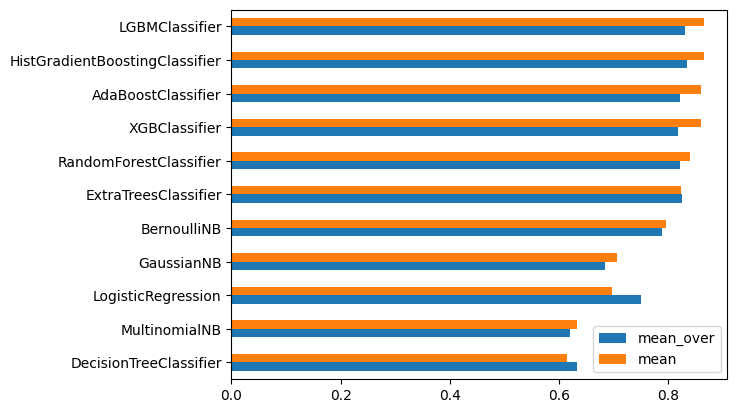

In [20]:
df_compare = pd.DataFrame(results_oversampling['mean']).rename(columns={'mean':'mean_over'})
df_compare = df_compare.join(results_unbalanced['mean'])
df_compare = df_compare.sort_values(by=['mean'], ascending=True)
ax = df_compare.plot.barh()

In [21]:
df_compare = df_compare.sort_values(by=['mean'], ascending=False)
df_compare['difference'] = df_compare['mean_over'] - df_compare['mean']
df_compare

,mean_over,mean,difference
LGBMClassifier,0.831334,0.864984,-0.033649
HistGradientBoostingClassifier,0.833341,0.864955,-0.031614
AdaBoostClassifier,0.821372,0.859480,-0.038108
XGBClassifier,0.817795,0.858935,-0.041140
RandomForestClassifier,0.821493,0.840187,-0.018693
ExtraTreesClassifier,0.824338,0.823433,0.000905
BernoulliNB,0.788732,0.795880,-0.007148
GaussianNB,0.684538,0.705393,-0.020855
LogisticRegression,0.749066,0.696028,0.053038
MultinomialNB,0.620249,0.633364,-0.013116


As we can see, oversampling made more harm than good in most of our models.

The best result was achieved by **LGBMClassifier**. Let's fine tuning it's parameters then.

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

### Hyperparameter Tuning

Since we're no longer using oversampling, we can perform optimization directly with cross_validation.

In [22]:
def param_opt(model, params, X, y, opt_method='', n_iter=10, score='roc_auc', n_splits=5, shuffle=False, n_jobs=4): 
  """
  Function to optimize algorithm hyperparameters
     If opt_method = 'Grid' then all combinations of hyperparameters will be tested for GridSearchCV
     If opt_method = 'Random', 10 hyperparameters will be tested randomly
     If opt_method = 'Bayes', 10 hyperparameters will be randomly tested and then Bayesian optimization will be performed (default)
  """

  # Defining kfold
  if shuffle == False:
    val_random = None
  kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=val_random)

  if opt_method.upper() == 'GRID':
    grid = GridSearchCV(model, params, cv=kfold, n_jobs=n_jobs, scoring=score)
  elif opt_method.upper() == 'RANDOM':
    grid = RandomizedSearchCV(model, params, cv=kfold, n_iter=n_iter, n_jobs=n_jobs, random_state=val_random, scoring=score)
  elif opt_method.upper() == 'BAYES':
    # Optimizers['GP', 'RF', 'ET', 'GBRT']: https://scikit-optimize.github.io/stable/modules/generated/skopt.Optimizer.html#skopt.Optimizer
    grid = BayesSearchCV(model, params, cv=kfold, n_iter=n_iter, n_jobs=n_jobs, optimizer_kwargs={'base_estimator':'GP'}, random_state=val_random, scoring=score)
  
  # Training model
  grid.fit(X, y)

  # Best hiperparameters
  best_params = dict(grid.best_params_)
  print("Best params:", best_params)
  
  # Best score
  best_score = grid.best_score_
  print(f"Best score({score}): {best_score:.5}\n")

  return best_params

In [23]:
# Listing hyperparameters
params = {}
params['num_leaves'] = [10, 20, 31, 50]                         # (default=31)
params['max_depth'] = [-1, 1]                                   # (default=-1)
params['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5]  # (default=0.1)
params['n_estimators'] = [50, 100, 150, 200, 250, 300]          # (default=100)
params['reg_alpha'] = [0., 0.0001, 0.001, 0.01, 0.1, 0.3]       # (default=0.)
params['reg_lambda'] = [0., 0.0001, 0.001, 0.01, 0.1, 0.3]      # (default=0.)
params['random_state'] = [42]                                   # (default=None)
params['n_jobs'] = [-1]                                         # (default=None)

n_comb = np.prod([len(params[key]) for key in params.keys()])
print(f'Possible matches: {n_comb}\n')

Possible matches: 10368



In [24]:
# Tuning hyperparameters Bayesian method
best_param_b = param_opt(model=LGBMClassifier(), params=params,
                       X=X_train, y=y_train, opt_method='bayes',
                       score='roc_auc', n_iter=50, n_splits=5)

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Best params: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 150, 'n_jobs': -1, 'num_leaves': 10, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.3}
Best score(roc_auc): 0.86528



In [25]:
# Tuning hyperparameters random method
best_param_r = param_opt(model=LGBMClassifier(), params=params,
                       X=X_train, y=y_train, opt_method='random',
                       score='roc_auc', n_iter=50, n_splits=5)

Best params: {'reg_lambda': 0.0001, 'reg_alpha': 0.3, 'random_state': 42, 'num_leaves': 10, 'n_jobs': -1, 'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.1}
Best score(roc_auc): 0.86517



In [26]:
best_param = best_param_b
best_param

{'learning_rate': 0.1,
 'max_depth': -1,
 'n_estimators': 150,
 'n_jobs': -1,
 'num_leaves': 10,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.3}

We have a tinny improvement compared with vanilla model, but it's better than nothing.

## Testing

As we're working with a kaggle challenge dataset, the test dataset don't have  labels. To verify the performance achieved by the model, we'll have to upload the prediction directly to the platform.

In [27]:
# Filling null values with median of df_train
X_test = df_test.drop(columns=['SeriousDlqin2yrs'])
X_test['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
X_test['NumberOfDependents'].fillna(fill_NumberOfDependents, inplace=True)

In [28]:
X_test.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [29]:
final_model = LGBMClassifier(**best_param).fit(X_train, y_train)

In [30]:
predicted_values = pd.DataFrame(final_model.predict_proba(X_test)[:, 1]).reset_index()
predicted_values.rename(columns={'index':'Id', 0:'Probability'}, inplace=True)
predicted_values['Id'] = predicted_values['Id'] + 1
predicted_values['Id'] = predicted_values['Id'].astype(int)
predicted_values

,Id,Probability
0,1,0.070637
1,2,0.050879
2,3,0.012675
3,4,0.082155
4,5,0.107086
...,...,...
101498,101499,0.033152
101499,101500,0.361082
101500,101501,0.006162
101501,101502,0.047450


In [31]:
# Exporting results
predicted_values.to_csv('predicted_values.csv', index=False, sep=',', decimal='.')

Kaggle returned scores **~0.867** for private score and **~0.861** for public score. It's a good result, considering that winer got **0.86955**.

Maybe we could improve that creating a stack with the top best performers, but if we would do that we will lost the ability of explainability, seen in next topic.

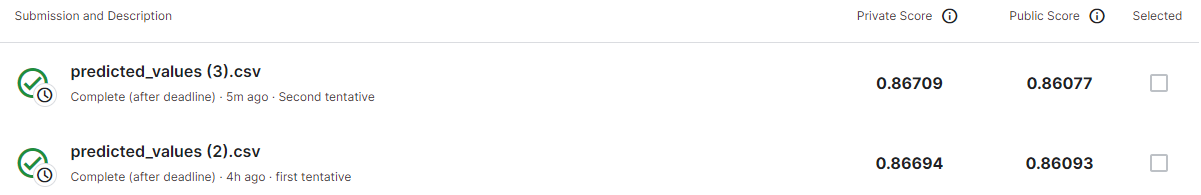

## Explaining

An important part of analysis is to understand which features the model considered most important for decision making. For this challenge, we are going to use SHAP.

In [32]:
def shapley_feature_ranking(shap_values, X, top=10):
  """
  Extract global values from SHAP
  """
  feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))
  return pd.DataFrame(
      {
          "features": [X.columns[i] for i in feature_order][::-1],
          "importance": [
              np.mean(np.abs(shap_values), axis=0)[i] for i in feature_order
          ][::-1],
      }
  ).head(top)

In [33]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


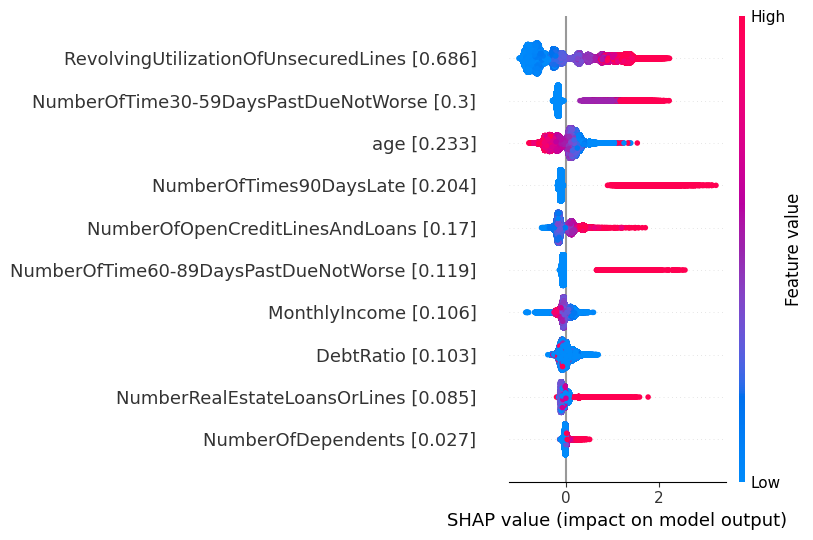

In [34]:
top_features = shapley_feature_ranking(shap_values[1], X_test, top=X_test.shape[1])
feat_name =  pd.merge(pd.DataFrame({'features':X_test.columns}), top_features, how="left", on=["features"])

feat_val = [
             col + " [" + str(round(feat_name.iloc[i]['importance'], 3)) + "]"
             for i, col in enumerate(feat_name['features'])
             ]

shap.summary_plot(shap_values[1], X_test, feature_names=feat_val, show=False)
plt.show()